In [120]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
small_bouts_df = pd.read_csv('/home/welling/Downloads/bouts (8).tsv', sep='\t')

In [4]:
small_bouts_df

,boutId,tourneyId,leftWins,leftPlayerId,rightPlayerId,rightWins,draws,note
0,5,3,2,7,6,1,0,NaN
1,6,3,1,6,8,1,0,NaN
2,7,3,1,6,12,1,0,NaN
3,8,3,0,6,9,1,0,NaN
4,9,3,2,6,10,3,1,NaN
5,10,3,2,6,11,0,0,NaN
6,11,3,2,7,8,2,0,NaN
7,12,3,2,7,12,0,0,NaN
8,13,3,1,7,10,1,0,NaN
9,14,3,2,7,11,1,0,NaN


In [276]:
n_players = 10
#n_players = 3
player_wts = np.zeros(n_players, dtype=float)

In [277]:
for i in range(n_players):
    player_wts[i] = i+1

In [278]:
npairs = 4000
outcomes = []
for pair in range(npairs):
    l_player = np.random.choice(range(n_players))
    r_player = np.random.choice(range(n_players-1))
    if r_player >= l_player:
        r_player += 1
    l_prob = player_wts[l_player] / (player_wts[l_player] + player_wts[r_player])
    if np.random.random() <= l_prob:
        outcomes.append({'l_player':l_player, 'r_player':r_player, 'l_wins':1, 'r_wins':0})
    else:
        outcomes.append({'l_player':l_player, 'r_player':r_player, 'l_wins':0, 'r_wins':1})
outcomes_df = pd.DataFrame(outcomes)

In [279]:
outcomes_df.head()

,l_player,r_player,l_wins,r_wins
0,3,2,1,0
1,2,6,0,1
2,4,3,1,0
3,3,0,1,0
4,1,7,0,1


In [280]:
totals_df = outcomes_df.groupby(['l_player','r_player']).sum()

In [281]:
totals_df = totals_df.reset_index()

In [282]:
totals_df

,l_player,r_player,l_wins,r_wins
0,0,1,20,28
1,0,2,10,40
2,0,3,15,28
3,0,4,5,39
4,0,5,7,38
...,...,...,...,...
85,9,4,38,19
86,9,5,18,17
87,9,6,23,15
88,9,7,33,14


In [283]:
def reorder_df(raw_df):
    merge_df_a = raw_df.rename(columns={'l_player':'player', 'r_player':'opponent', 'l_wins':'wins', 'r_wins':'losses'})
    merge_df_a['bouts'] = merge_df_a['wins'] + merge_df_a['losses']
    merge_df_b = raw_df.rename(columns={'r_player':'player', 'l_player':'opponent', 'r_wins':'wins', 'l_wins':'losses'})
    merge_df_b['bouts'] = merge_df_b['wins'] + merge_df_b['losses']
    return pd.concat([merge_df_a, merge_df_b], axis=0).groupby(['player','opponent']).sum().reset_index()

In [284]:
def initialize(n_players, n_chains=1):
    return np.ones((n_chains, n_players))

In [285]:
def mutate(w_vec, idx, rng, sigma=1.0):
    n_chains, n_players = w_vec.shape
    norm_samp = rng.standard_normal(size=n_chains)
    scale_fac = np.exp(norm_samp)
    rslt = w_vec.copy()
    rslt[:,idx] *= scale_fac
    return rslt

In [353]:
def calc_p_ratio(idx, old_wts, new_wts, samples_df):
    n_chains, n_players = old_wts.shape
    col_d = {nm:idx for idx, nm in enumerate(samples_df.columns)}
    player_col = col_d['player']
    opp_col = col_d['opponent']
    wins_col = col_d['wins']
    bouts_col = col_d['bouts']
    df_mtx = samples_df.values
    mask = df_mtx[:, player_col] == idx
    sub_df_mtx = df_mtx[mask, :]
    n_opp = sub_df_mtx.shape[0]
    
    w = old_wts[:, idx]
    wprime = new_wts[:, idx]
    log_w_ratio = np.log(wprime/w)
    op_idx = sub_df_mtx[:, opp_col]
    w_op = old_wts[:, op_idx]
    p1 = np.log((w[:, None] + w_op)/(wprime[:, None] + w_op))
    p2 = sub_df_mtx[:, bouts_col]
    tot = np.outer(log_w_ratio, sub_df_mtx[:, wins_col]) + np.einsum('ij,j -> ij', p1, p2)
    return np.exp(np.sum(tot, axis=1))

In [345]:
def sweep(w_vec, win_loss_df, rng, sigma):
    n_chains, n_players = w_vec.shape
    for idx in range(n_players):
        mutated_w_vec = mutate(w_vec, idx, rng, sigma=sigma)
        p_ratio = calc_p_ratio(idx, w_vec, mutated_w_vec, win_loss_df)
        choice_vec = (np.random.random(n_chains) <= p_ratio)
        w_vec = np.where(choice_vec[:, None], mutated_w_vec, w_vec)
    return w_vec

Base time:
```
CPU times: user 2min 16s, sys: 293 ms, total: 2min 16s
Wall time: 2min 15s
```

First pass chaining:
```
CPU times: user 26.2 s, sys: 220 ms, total: 26.4 s
Wall time: 25.9 s
```

300 burn-in, 20 threads, 5 samples per thread:
```
CPU times: user 10.4 s, sys: 44.1 ms, total: 10.4 s
Wall time: 10.3 s
```

Convert calc_p_ratios to numpy, stage 1
```
CPU times: user 1.25 s, sys: 32.7 ms, total: 1.28 s
Wall time: 1.23 s
```

Convert calc_p_ratois to numpy, stage 2
```
CPU times: user 900 ms, sys: 16.1 ms, total: 916 ms
Wall time: 895 ms
```

In [354]:
%%time
burnin_sweeps = 300
n_samp = 5
sweeps_per_samp = 100
n_chains = 20
rng = np.random.default_rng()
n_players = len(player_wts)  # we are trying to infer player_wts
w_vec = initialize(n_players, n_chains)
reordered_df = reorder_df(totals_df)
# burn-in
for iter in range(burnin_sweeps):
    w_vec = sweep(w_vec, reordered_df, rng, sigma=0.1)
    w_vec /= w_vec[:, 0, None]  # rescale
print('burn-in complete')
samp_l = []
for samp in range(n_samp):
    for iter in range(sweeps_per_samp):
        w_vec = sweep(w_vec, reordered_df, rng, sigma=0.1)
        w_vec /= w_vec[:, 0, None]  # rescale
    samp_l.append(w_vec.copy())
    print(samp)


burn-in complete
0
1
2
3
4
CPU times: user 796 ms, sys: 40.8 ms, total: 837 ms
Wall time: 787 ms


In [355]:
n_chains, n_players = samp_l[0].shape
samp_array = np.empty((len(samp_l), n_chains, n_players))
for idx, vec in enumerate(samp_l):
    samp_array[idx, :, :] = vec
samp_array = samp_array.reshape(-1, n_players)

AxesSubplot(0.125,0.125;0.775x0.755)


<ipython-input-356-b94447bfe202>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


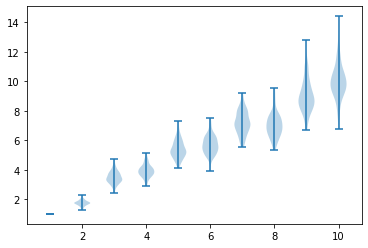

In [356]:
fig, axes = plt.subplots(ncols=1, nrows=1)
print(axes)
axes.violinplot(samp_array)
fig.show()

AxesSubplot(0.125,0.125;0.775x0.755)


<ipython-input-178-b94447bfe202>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


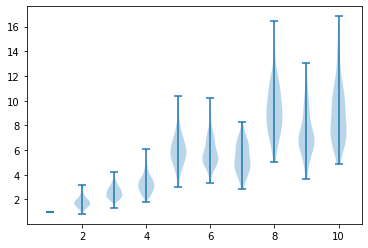

In [178]:
fig, axes = plt.subplots(ncols=1, nrows=1)
print(axes)
axes.violinplot(samp_array)
fig.show()

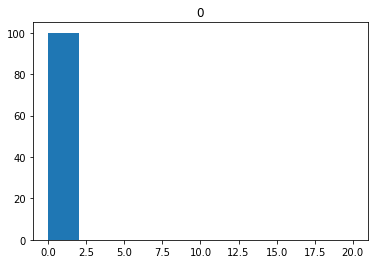

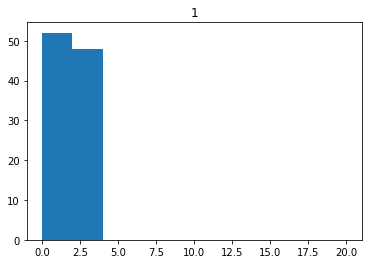

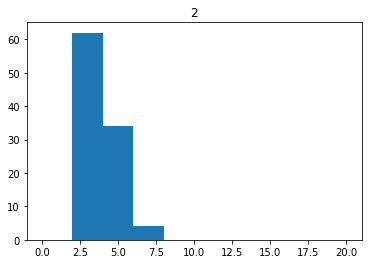

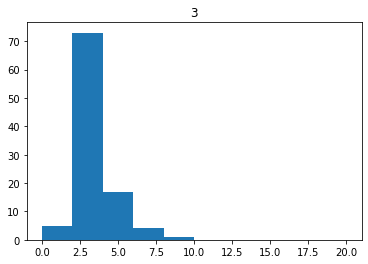

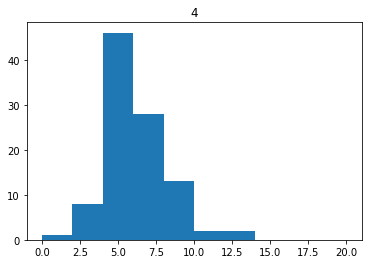

In [143]:
for idx in range(n_players):
    plt.title(idx)
    plt.hist([v[idx] for v in samp_l], range=[0.0, 20.0])
    plt.show()

In [125]:
rng = np.random.default_rng()
for i in range(7):
    w_vec = mutate(w_vec, 3, rng, sigma=0.2)
    print(w_vec)

[1.00000000e+00 3.15354013e+00 2.92204429e+00 4.30306593e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 8.19315573e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 9.05832120e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 1.57036131e+02
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 1.80674142e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 3.91368396e+01
 2.37436278e+01 3.64135760e+00 1.75989108e+01 6.19411295e+20
 4.73572270e+00 3.36279305e+00]
[1.00000000e+00 3.15354013e+00 2.92204429e+00 2.73565981e+01
 2.37436278e+01

In [38]:
rng = np.random.default_rng()
print(rng.standard_normal(size=100))

[ 4.62751278e-02  1.92739976e-02  2.78453598e-01  5.56477021e-01
  1.50966000e+00 -8.59554544e-01 -4.12515716e-01 -4.90642342e-01
 -7.46452047e-02 -7.80648762e-01  1.39380560e-01  9.16690735e-01
  7.45714988e-02 -3.56676673e-01 -1.60829870e+00 -1.50534317e+00
 -7.60107090e-01  1.75279543e-03 -6.61985602e-01 -4.68890654e-01
 -1.25296501e+00 -5.55339603e-01 -1.14217426e+00 -6.26829145e-01
 -1.07976453e+00 -6.18942823e-02  1.69316490e-01  3.09991587e-01
 -1.57735870e-01  1.07652204e+00 -4.08117920e-01 -1.06473028e+00
 -1.12165387e+00 -3.00579397e-01  6.64806317e-03 -8.18626754e-01
  7.17753204e-01 -1.94787020e-01  4.43364966e-01 -2.54610208e+00
  3.45116098e-03  3.75138695e-01  7.27154067e-01  1.11486866e+00
  3.01304508e-01 -6.01177562e-02 -3.39415303e-01  1.91238957e-01
 -3.94445151e-01 -1.21892141e+00 -4.78977608e-01  1.37289827e+00
  3.57562885e-01  1.54901666e+00 -9.30178446e-01 -8.82320579e-01
 -1.11705626e+00 -2.44797777e-01  1.16731784e-01 -1.67903976e-01
  2.88643286e-01 -1.05303

In [230]:
w_vec = initialize(3, 5)
rng = np.random.default_rng()
idx = 1
reordered_df = reorder_df(totals_df)
mutated_vec = mutate(w_vec, idx, rng, sigma=1.0)
display(mutated_vec)
p_ratio = calc_p_ratio(idx, w_vec, mutated_vec, reordered_df)

array([[1.        , 0.38899855, 1.        ],
       [1.        , 1.89966363, 1.        ],
       [1.        , 0.15788295, 1.        ],
       [1.        , 0.47634786, 1.        ],
       [1.        , 0.89908606, 1.        ]])

idx 1: [1. 1. 1. 1. 1.] -> [0.38899855 1.89966363 0.15788295 0.47634786 0.89908606]:
player         1
opponent       0
wins         876
losses       445
bouts       1321
Name: 2, dtype: int64
player         1
opponent       2
wins         500
losses       814
bouts       1314
Name: 3, dtype: int64


<ipython-input-229-1f2dfd962959>:12: RuntimeWarning: overflow encountered in power
  p_ratio *= np.power((w + w_op)/(wprime + w_op), row['bouts'])
<ipython-input-229-1f2dfd962959>:12: RuntimeWarning: invalid value encountered in multiply
  p_ratio *= np.power((w + w_op)/(wprime + w_op), row['bouts'])
